In [299]:
import numpy as np
import matplotlib.pyplot as pl
import matplotlib as mpl
import pandas as pd
from astropy.table import Table
from scipy.interpolate import interp1d
import read_mist_models
import sys
sys.path.append('..')
import analysis_utils

highlight = np.array((66, 135, 245))/255
red = '#FE4365'
blue = '#00A9FF'
yellow = '#ECA25C'
green = '#3F9778'
darkblue = '#005D7F'

In [300]:
import os
data = pd.DataFrame()
for file in os.listdir('../output/txtoutput'):
    print("reading file: {0}".format(file))
    data = data.append(pd.read_csv('../output/txtoutput/'+file, skiprows=1, delimiter='\t'))

reading file: out18.dat
reading file: out3.dat


/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


reading file: out2.dat
reading file: out1.dat
reading file: out5.dat
reading file: out4.dat
reading file: out6.dat


In [301]:
k2dr2 = Table.read('k2_dr2_1arcsec.fits', format='fits')
k2dr2 = k2dr2.to_pandas()
epic = Table.read('epic.fits', format='fits')
epic = epic.to_pandas()
df = pd.merge(k2dr2, data, left_on='epic_number', right_on='epic')
df = pd.merge(df, epic, left_on='epic_number', right_on='ID')
df = df.drop_duplicates(subset='epic_number')

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2963: TableReplaceWarning: converted column 'r_result_flag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2963: TableReplaceWarning: converted column 'r_modality_flag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2963: TableReplaceWarning: converted column 'k2_kepmagerr' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


In [357]:
import imp
imp.reload(analysis_utils)
ms = analysis_utils.selectms(
    df, 
    'MIST_iso_5da0dbfba0a60.iso.cmd', 
    dist_range=(0, np.inf), 
    bp_rp_range=(0.0, 5.0),
    g_rp_range=(0.0, 5.0),
    width=(-0.4, 0.4)
)

Reading in: MIST_iso_5da0dbfba0a60.iso.cmd


/usr/local/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(0.5, 4.5)

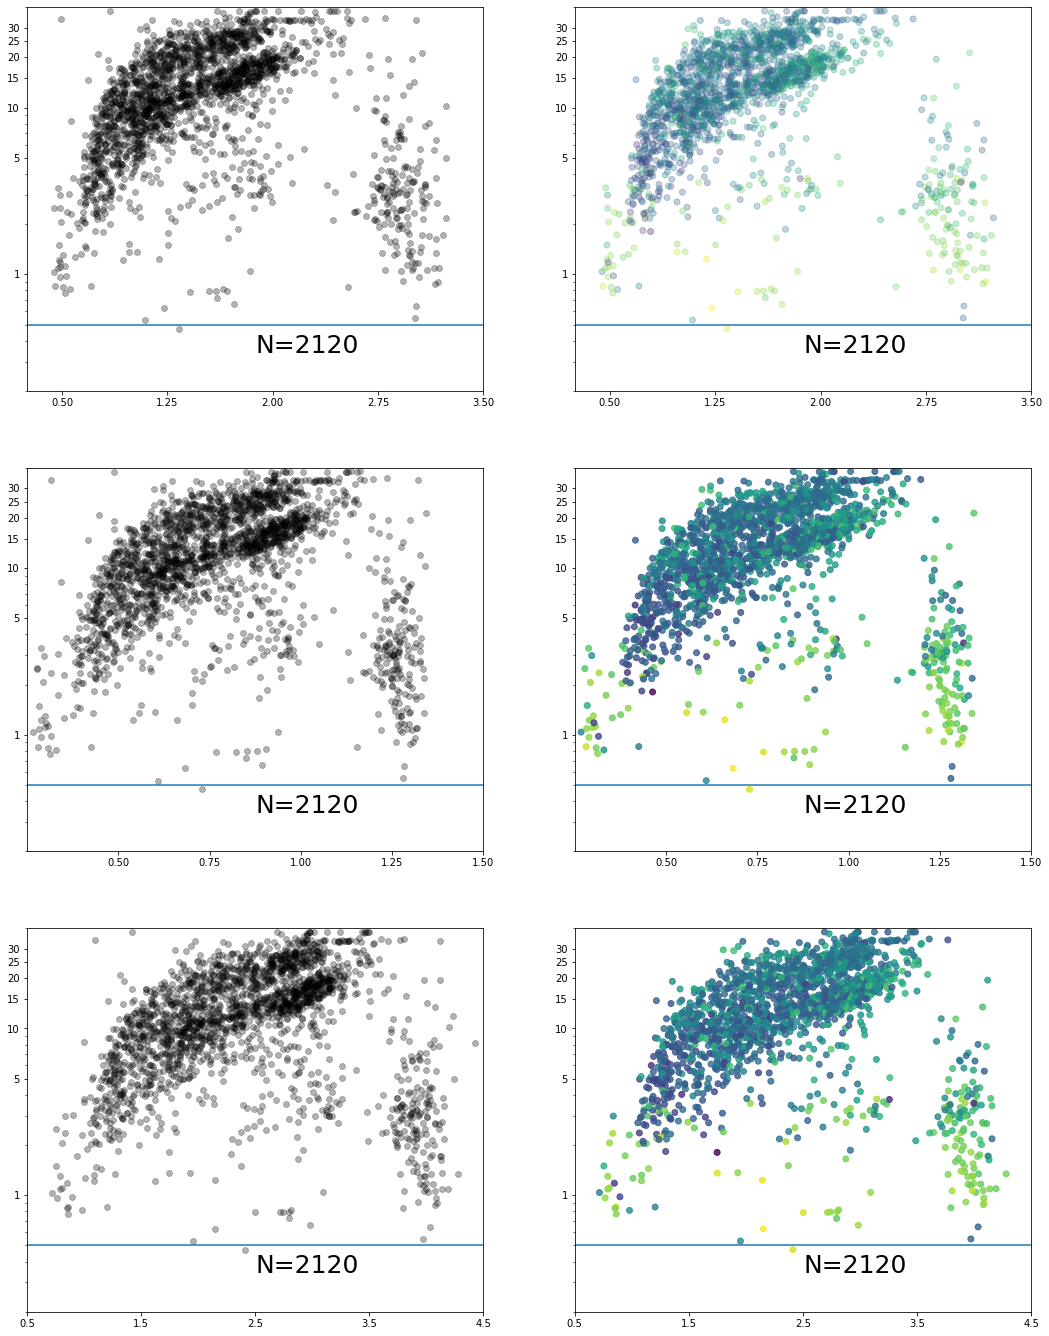

In [872]:
good_P = ms['P_mean'] / ms['P_sd'] > 20
good_P = good_P & (ms['P_mean'] < 38)
#good_P = good_P & (np.abs(ms['P_r_hat'] - 1.0) < 0.1)
good_P = good_P & ((ms['logamp_mean'] - ms['logS0_mean']) > np.log(1e-3))
#good_P = good_P & (ms['mix_mean'] > 0.15)
#color = ms['P_mean'] - ms['P_mode']
#color = ms['mix_mode']
tau1 = ms['P_mean']*np.sqrt(np.exp(ms['logQ0_mean'])**2 - 1)
tau2 = ms['P_mean']*np.sqrt((np.exp(ms['logQ0_mean'])+ np.exp(ms['logdQ_mean']))**2 - 1)
color = np.log(tau1 + tau2)

fig, axs = pl.subplots(3, 2, figsize=(18, 24))
axs[0, 0].semilogy(ms[good_P]['bp_rp'], ms[good_P]['P_mean'], 'o', color='k', 
            markeredgewidth=0.75, markeredgecolor='k', alpha=0.3)
axs[0, 1].scatter(ms[good_P]['bp_rp'], ms[good_P]['P_mean'], c=color[good_P], alpha=0.3)
axs[0, 1].set_yscale('log')

axs[1, 0].semilogy(ms[good_P]['g_rp'], ms[good_P]['P_mean'], 'o', color='k', 
            markeredgewidth=0.75, markeredgecolor='k', alpha=0.3)
axs[1, 1].scatter(ms[good_P]['g_rp'], ms[good_P]['P_mean'], c=color[good_P], alpha=0.8)
axs[1, 1].set_yscale('log')

axs[2, 0].semilogy(ms[good_P]['phot_g_mean_mag']-ms[good_P]['Ksmag'], ms[good_P]['P_mean'], 'o', color='k', 
            markeredgewidth=0.75, markeredgecolor='k', alpha=0.3)
axs[2, 1].scatter(ms[good_P]['phot_g_mean_mag']-ms[good_P]['Ksmag'], ms[good_P]['P_mean'], c=color[good_P], alpha=0.8)
axs[2, 1].set_yscale('log')

[ax.yaxis.set_major_formatter(pl.ScalarFormatter()) for ax in axs.flatten()]
[ax.set_yticks([1, 5, 10, 15, 20, 25, 30]) for ax in axs.flatten()]
[ax.set_xticks(np.linspace(0.5, 3.5, 5)) for ax in axs[0]]
[ax.set_xticks(np.linspace(0.5, 1.5, 5)) for ax in axs[1]]
[ax.set_xticks(np.linspace(0.5, 4.5, 5)) for ax in axs[2]]
[ax.annotate('N={0}'.format(np.sum(good_P)), xy=(0.5, 0.1), 
            xycoords='axes fraction', fontsize=25) for ax in axs.flatten()]
[ax.set_ylim(0.2, 40) for ax in axs.flatten()]
[ax.axhline(0.5) for ax in axs.flatten()]
axs[1, 0].set_xlim(0.25, 1.5)
axs[1, 1].set_xlim(0.25, 1.5)
axs[0, 0].set_xlim(0.25, 3.5)
axs[0, 1].set_xlim(0.25, 3.5)
axs[2, 0].set_xlim(0.5, 4.5)
axs[2, 1].set_xlim(0.5, 4.5)

/usr/local/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


[Text(0, 0.5, '$\\tau$'), Text(0, 0.5, '$\\tau$')]

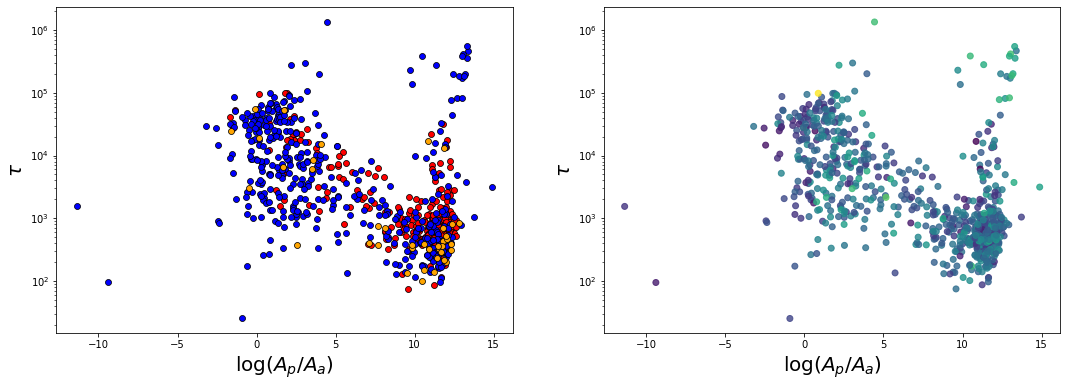

In [911]:
good_P = ms['P_mean'] / ms['P_sd'] > 20
good_P = good_P & (ms['P_mean'] < 38)
good_P = good_P & (np.abs(ms['P_r_hat'] - 1.0) < 0.1)
#good_P = good_P & ((ms['logamp_mean'] - ms['logS0_mean']) > np.log(1e-3))
#good_P = good_P & (ms['mix_mean'] > 0.15)
#good_P = good_P & (ms['mix_mean'] < 0.85)
good_P = good_P & (ms['bp_rp'] > 1.4) & (ms['bp_rp'] < 2.4)
color = ms['logamp_mean']
tau1 = ms['P_mean']*np.sqrt(np.exp(ms['logQ0_mean'])**2 - 1)
tau2 = ms['P_mean']*np.sqrt((np.exp(ms['logQ0_mean'])+ np.exp(ms['logdQ_mean']))**2 - 1)
logaharm_amp = ms['logS0_mean'] + ms['logw_mean'] - np.log(np.sqrt(2))

x0u, au, bu = -0.91, -25.69, 23.95
upper = lambda x: (au*(x-x0u)**0.5) + (bu*(x-x0u))
x0l, al, bl, cl = 1.32, 83.66, -157.97, 109.55
lower = lambda x: (al*(x-x0l)**0.5) + (bl*(x-x0l)) + (cl*(x-x0l)**(3/2))
above = good_P & (ms['P_mean'] > upper(ms['bp_rp']))
middle = good_P & (ms['P_mean'] < upper(ms['bp_rp'])) & (ms['P_mean'] > lower(ms['bp_rp']))
below = good_P & (ms['P_mean'] < lower(ms['bp_rp']))

key_x = 'P_mean'
key_y = 'logS0_mean'
x = ms[good_P]['logamp_mean'] - logaharm_amp[good_P]# - upper(ms[good_P]['bp_rp'])
#x = ms[good_P]['P_mean']
y = tau2[good_P] + tau1[good_P]
#x = resid_P[good_P]

xf = ms[above]['logamp_mean'] - logaharm_amp[above]# - upper(ms[above]['bp_rp'])
#xf = ms[above]['P_mean']
yf = tau2[above] + tau1[above]
#yf = resid_P[good_P & above]
xs = ms[below]['logamp_mean'] - logaharm_amp[below]# - upper(ms[below]['bp_rp'])
#xs = ms[below]['P_mean']
ys = tau2[below] + tau1[below]
#ys = resid_P[good_P & below]

xm = ms[middle]['logamp_mean'] - logaharm_amp[middle]# - upper(ms[middle]['bp_rp'])
#xm = ms[middle]['P_mean']
ym = tau2[middle] + tau1[middle]
#ym = resid_P[good_P & middle]

fig, axs = pl.subplots(1, 2, figsize=(18, 6))
#axs[0].plot(x, y, 'o', color='k', 
#            markeredgewidth=0.75, markeredgecolor='k', alpha=0.3)
axs[1].scatter(x, y, c=color[good_P], alpha=0.8)

axs[0].plot(xf, yf, 'o', color='r', 
            markeredgewidth=0.75, markeredgecolor='k', alpha=1)
axs[0].plot(xs, ys, 'o', color='b', 
            markeredgewidth=0.75, markeredgecolor='k', alpha=1)
axs[0].plot(xm, ym, 'o', color='orange', 
            markeredgewidth=0.75, markeredgecolor='k', alpha=1)

[ax.set_yscale('log') for ax in axs]
[ax.set_xlabel(r'log$(A_p/A_a)$', fontsize=20) for ax in axs]
[ax.set_ylabel(r'$\tau$', fontsize=20) for ax in axs]
#[ax.set_xlim(0, 0.5*1e6) for ax in axs]
#[ax.axvline(1) for ax in axs]

[(10.0, 1000000.0), (10.0, 1000000.0), (10.0, 1000000.0)]

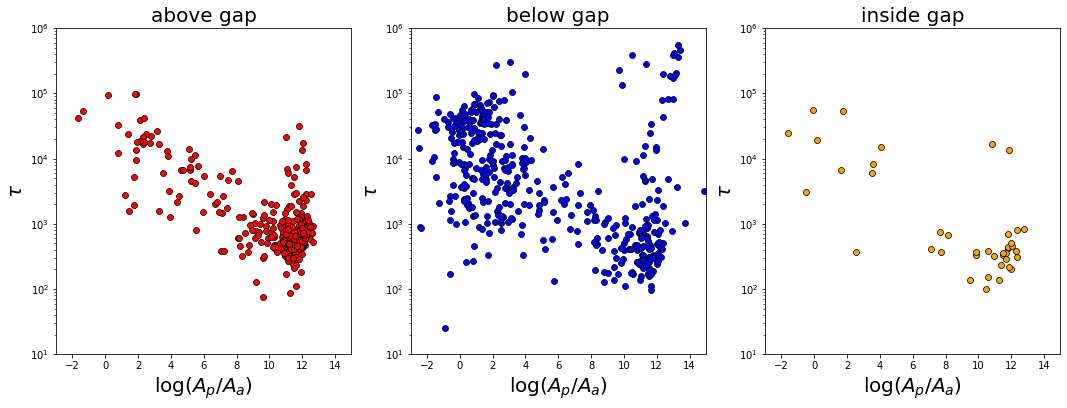

In [917]:
fig, axs = pl.subplots(1, 3, figsize=(18, 6))
#axs[0].plot(x, y, 'o', color='k', 
#            markeredgewidth=0.75, markeredgecolor='k', alpha=0.3)
#axs[1].scatter(x, y, c=color[good_P], alpha=0.8)

axs[0].plot(xf, yf, 'o', color='r', 
            markeredgewidth=0.75, markeredgecolor='k', alpha=1)
axs[0].set_title('above gap', fontsize=20)
axs[1].plot(xs, ys, 'o', color='b', 
            markeredgewidth=0.75, markeredgecolor='k', alpha=1)
axs[1].set_title('below gap', fontsize=20)
axs[2].plot(xm, ym, 'o', color='orange', 
            markeredgewidth=0.75, markeredgecolor='k', alpha=1)
axs[2].set_title('inside gap', fontsize=20)

[ax.set_yscale('log') for ax in axs]
[ax.set_xlabel(r'log$(A_p/A_a)$', fontsize=20) for ax in axs]
[ax.set_ylabel(r'$\tau$', fontsize=20) for ax in axs]
[ax.set_xlim(-3, 15) for ax in axs]
[ax.set_ylim(1e1, 1e6) for ax in axs]
#[ax.axvline(1) for ax in axs]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


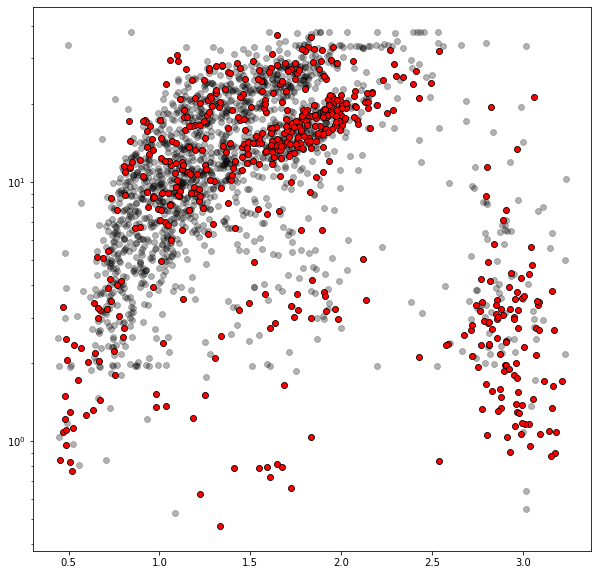

In [866]:
good_P = ms['P_mean'] / ms['P_sd'] > 20
good_P = good_P & (ms['P_mean'] < 38)
#good_P = good_P & (np.abs(ms['P_r_hat'] - 1.0) < 0.1)
#good_P = good_P & ((ms['logamp_mean'] - ms['logS0_mean']) > np.log(1e-3))
#good_P = good_P & (ms['mix_mean'] > 0.15)
#color = ms['P_mean'] - ms['P_mode']
color = ms['logamp_mean']

pl.figure(figsize=(10, 10))
pl.semilogy(ms[good_P]['bp_rp'], ms[good_P]['P_mean'], 'o', color='k', 
            markeredgewidth=0.75, markeredgecolor='k', alpha=0.3)
pl.yscale('log')

pl.semilogy(ms[good_P][(tau1 + tau2) > 5e3]['bp_rp'], ms[good_P][(tau1 + tau2) > 5e3]['P_mean'], 'o', color='r', 
            markeredgewidth=0.75, markeredgecolor='k', alpha=1)
pl.yscale('log')

#pl.semilogy(ms[good_P][tau < 1e3]['bp_rp'], ms[good_P][tau < 1e3]['P_mean'], 'o', color='b', 
#            markeredgewidth=0.75, markeredgecolor='k', alpha=1)
#pl.yscale('log')

(array([ 66.,  32.,  43.,  57.,  76., 123., 122., 145., 105.,  61.]),
 array([0.    , 0.0738, 0.1476, 0.2214, 0.2952, 0.369 , 0.4428, 0.5166,
        0.5904, 0.6642, 0.738 ]),
 <a list of 10 Patch objects>)

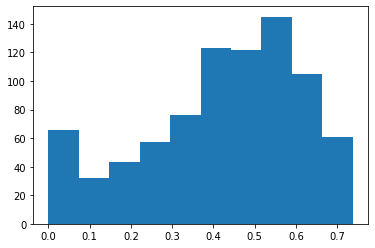

In [858]:
pl.hist(ms[good_P]['mix_mean'])

/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(-3.0, 7.0)

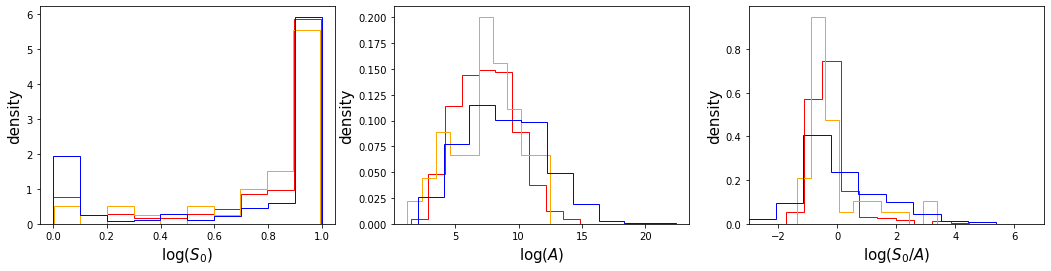

In [769]:
fig, axs = pl.subplots(1, 3, figsize=(18, 4))

axs[0].hist(tau1[above]/tau2[above], density=True, color='r', histtype='step');
axs[0].hist(tau1[middle]/tau2[middle],  density=True, color='orange', histtype='step');
axs[0].hist(tau1[below]/tau2[below], density=True, color='b', histtype='step');
axs[0].set_ylabel('density', fontsize=15)
axs[0].set_xlabel(r'log($S_0$)', fontsize=15)

axs[1].hist(ms[above]['logamp_mean'], density=True, color='r', histtype='step');
axs[1].hist(ms[middle]['logamp_mean'], density=True, color='orange', histtype='step');
axs[1].hist(ms[below][resid_P > -10]['logamp_mean'], density=True, color='b', histtype='step');
axs[1].set_ylabel('density', fontsize=15)
axs[1].set_xlabel(r'log($A$)', fontsize=15)

axs[2].hist(ms[above]['logS0_mean']-ms[above]['logamp_mean'], density=True, color='r', histtype='step');
axs[2].hist(ms[middle]['logS0_mean']-ms[middle]['logamp_mean'], density=True, color='orange', histtype='step');
axs[2].hist(ms[below][resid_P > -10]['logS0_mean']-ms[below][resid_P > -10]['logamp_mean'], 
            density=True, color='b', histtype='step', bins=20);
axs[2].set_ylabel('density', fontsize=15)
axs[2].set_xlabel(r'log($S_0/A$)', fontsize=15)
axs[2].set_xlim(-3, 7)

In [433]:
list(ms.columns)

['solution_id',
 'designation',
 'source_id',
 'random_index',
 'gaia_ref_epoch',
 'ra',
 'ra_error',
 'dec',
 'dec_error',
 'parallax',
 'parallax_error',
 'parallax_over_error',
 'pmra',
 'pmra_error',
 'pmdec',
 'pmdec_error',
 'ra_dec_corr',
 'ra_parallax_corr',
 'ra_pmra_corr',
 'ra_pmdec_corr',
 'dec_parallax_corr',
 'dec_pmra_corr',
 'dec_pmdec_corr',
 'parallax_pmra_corr',
 'parallax_pmdec_corr',
 'pmra_pmdec_corr',
 'astrometric_n_obs_al',
 'astrometric_n_obs_ac',
 'astrometric_n_good_obs_al',
 'astrometric_n_bad_obs_al',
 'astrometric_gof_al',
 'astrometric_chi2_al',
 'astrometric_excess_noise',
 'astrometric_excess_noise_sig',
 'astrometric_params_solved',
 'astrometric_primary_flag',
 'astrometric_weight_al',
 'astrometric_pseudo_colour',
 'astrometric_pseudo_colour_error',
 'mean_varpi_factor_al',
 'astrometric_matched_observations',
 'visibility_periods_used',
 'astrometric_sigma5d_max',
 'frame_rotator_object_type',
 'matched_observations',
 'duplicated_source',
 'phot_g

In [217]:
ms[ms['logQ0_mean'] < -5][ms['P_mean'] < 2]['k2_campaign_str']

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


10222      b'1'
50180     b'15'
84040      b'3'
92430      b'3'
109153     b'5'
          ...  
200219     b'5'
200227    b'18'
200244    b'18'
200383    b'18'
200413     b'5'
Name: k2_campaign_str, Length: 785, dtype: object

In [ ]:
good_P = ms1['P_mean'] / ms1['P_sd'] > 20
good_P = good_P & (ms1['P_mean'] < 30)
#good_P = good_P & (ms1['logamp_mean'] - np.log(ms1['yerr_mean']) > 4)
#good_P = good_P & (ms['P_ess_mean'] > 7000)
good_P = good_P & (np.abs(ms1['P_r_hat'] - 1.0) < 0.01)
color = ms1['logamp_mean'] - np.log(ms1['yerr_mean'])

fig, axs = pl.subplots(1, 2, figsize=(18, 8))
#fig, axs = pl.subplots(1, 2, figsize=(18, 8))
axs[0].semilogy(ms1[good_P]['bp_rp'], ms1[good_P]['P_mean'], 'o', color='k', 
            markeredgewidth=0.75, markeredgecolor='k', alpha=0.3)
axs[1].scatter(ms1[good_P]['bp_rp'], ms1[good_P]['P_mean'], c=color[good_P])
axs[1].set_yscale('log')
[ax.yaxis.set_major_formatter(pl.ScalarFormatter()) for ax in axs]
[ax.set_yticks([1, 5, 10, 15, 20, 25, 30]) for ax in axs]
[ax.set_xticks(np.linspace(0.5, 2.5, 5)) for ax in axs]
[ax.annotate('N={0}'.format(np.sum(good_P)), xy=(0.7, 0.0), 
            xycoords='axes fraction', fontsize=25) for ax in axs]
#[ax.set_ylim(1, 35) for ax in axs]
#[ax.set_xlim(0.25, 2.5) for ax in axs]

In [ ]:
list(k2dr2.columns)

In [136]:
list(ms.columns)

['solution_id',
 'designation',
 'source_id',
 'random_index',
 'gaia_ref_epoch',
 'ra',
 'ra_error',
 'dec',
 'dec_error',
 'parallax',
 'parallax_error',
 'parallax_over_error',
 'pmra',
 'pmra_error',
 'pmdec',
 'pmdec_error',
 'ra_dec_corr',
 'ra_parallax_corr',
 'ra_pmra_corr',
 'ra_pmdec_corr',
 'dec_parallax_corr',
 'dec_pmra_corr',
 'dec_pmdec_corr',
 'parallax_pmra_corr',
 'parallax_pmdec_corr',
 'pmra_pmdec_corr',
 'astrometric_n_obs_al',
 'astrometric_n_obs_ac',
 'astrometric_n_good_obs_al',
 'astrometric_n_bad_obs_al',
 'astrometric_gof_al',
 'astrometric_chi2_al',
 'astrometric_excess_noise',
 'astrometric_excess_noise_sig',
 'astrometric_params_solved',
 'astrometric_primary_flag',
 'astrometric_weight_al',
 'astrometric_pseudo_colour',
 'astrometric_pseudo_colour_error',
 'mean_varpi_factor_al',
 'astrometric_matched_observations',
 'visibility_periods_used',
 'astrometric_sigma5d_max',
 'frame_rotator_object_type',
 'matched_observations',
 'duplicated_source',
 'phot_g